# Máquinas de soporte vectorial

por Mónica Tatiana Gutierrez Ballen

version 1.0, Agosto 2021

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Rick Muller](http://www.cs.sandia.gov/~rmuller/), Sandia National Laboratories



## Motivación de las máquinas de vectores de apoyo

Las máquinas de vectores de apoyo (SVM) son un potente algoritmo de aprendizaje supervisado que se utiliza para la clasificación o la regresión. 

Desarrollado por Vladimir Vapnik en la decada de los años 90, como una solución a problemas en el campo computacional. Inicialmente se desarrolló como un algoritmo de clasificación binaria, sin embargo su desarrollo ha sido tal que actualmente se utiliza adicionalmente para problemas de clasificación multiclase y regresión. A diferencia de los modelos modelos de *clasificación generativa*, SVM se puede ver como un método de *clasificación discriminativa*, el cual encuentra una superficie que divide las clases entre sí.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

Como ejemplo se tiene un conjunto de entrenamiento en el cual, las observaciones pertenencen a dos clases linealmente separables.

[[1.41281595 1.5303347 ]
 [1.81336135 1.6311307 ]
 [1.43289271 4.37679234]
 [1.87271752 4.18069237]
 [2.09517785 1.0791468 ]
 [2.73890793 0.15676817]] [1 1 0 0 1 1]


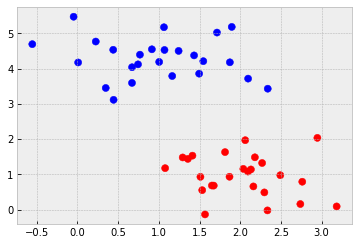

In [ ]:
plt.style.use('bmh')
### grafica 1
X_train, y_train = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
print(X_train[:6],y_train[:6])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap = 'bwr')
plt.show()

Un clasificador de tipo discriminativo, intenta dibujar un recta que separa las clases en el conjunto de datos, creando así un modelo de clasificación. Sin embargo, existe más de una posible línea divisoria:

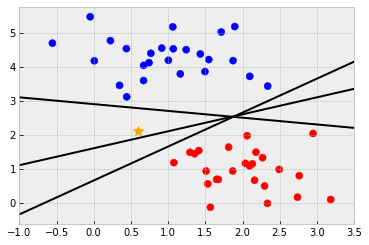

In [ ]:
### grafica 2
x = np.linspace(-1, 3.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='bwr')
plt.plot([0.6], [2.1], '*', color='orange', markersize=10)

for w, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(x, w * x + b, '-k')
plt.xlim(-1, 3.5)
plt.show()

Las anteriores tres lineas discriminan perfectamente, sin embargo dependiendo de la elegida, un nuevo punto puede quedar clasificado como una u otra categoría, por lo que trazar solo una línea es insuficieente, se necesita algo más.



## Maximizar el margen

Las SVM ofrecen la posibilidad de mejorar esto. Si en lugar de simplemente dibujar una sola línea, se dibuja alrededor de cada línea un *margen* de cierto ancho al punto más cercano de cada clase, su podría obtener otra regla de clasificación. La línea que maximiza este margen, es la escogida como la óptima en el modelo.

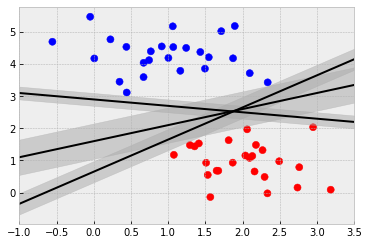

In [ ]:
### grafica 3
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='bwr')

for w, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yhat = w * x + b
    plt.plot(x, yhat, '-k')
    plt.fill_between(x, yhat - d, yhat + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.5)

plt.xlim(-1, 3.5)
plt.show()

Obsérvese que si queremos maximizar esta amplitud, el ajuste medio es claramente el mejor. Esta es la intuición de las máquinas de vectores de apoyo, que optimizan un modelo discriminante lineal junto con un margen que representa la distancia perpendicular entre los conjuntos de datos.


## Ajuste de una máquina de vectores de apoyo

Ahora ajustaremos un clasificador de máquina de vectores de apoyo a estos puntos. Aunque los detalles matemáticos del modelo de verosimilitud son interesantes, los leeremos en otra parte. En su lugar, vamos a tratar el algoritmo de scikit-learn como una caja negra que lleva a cabo la tarea anterior.

## Un ejemplo
A continuación se ajustará un modelo de SVM a los datos de ejemplo para intuir como funciona. 

In [ ]:
from sklearn.svm import SVC
modSVC = SVC(kernel='linear', C=1E6)
modSVC.fit(X_train, y_train)

SVC(C=1000000.0, kernel='linear')

Los puntos que tocan los bordes del margen se conocen como *Vectores de Soporte*.

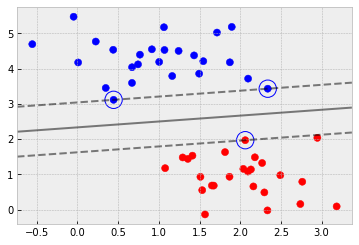

In [ ]:
def svc_plot(model, ax=None, plot_support=True):
    """Traza la función de decisión"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Grilla para evaluar el modelo
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Graficar los márgenes de decisión
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Vectores de soporte
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='b')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='bwr')
svc_plot(modSVC)

Los vectores de soporte son:

In [ ]:
print(modSVC.support_vectors_)

[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]


El éxito de éste modelo radica en el hecho que para su ajuste solo importa la posición de los vectores de soporte, los demás puntos no contribuyen en la función de perdida usada para ajustar el modelo.

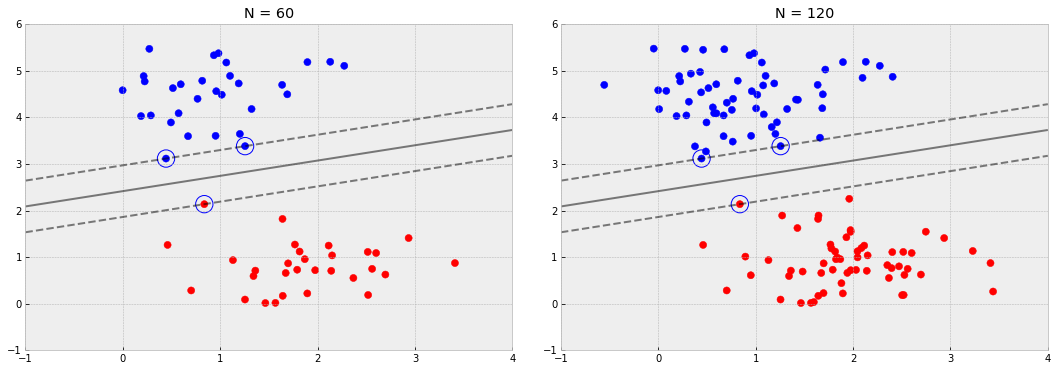

In [ ]:
def plot_svm(N=10, ax=None):
    X_train, y_train = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X_train = X_train[:N]
    y_train = y_train[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X_train, y_train)
    
    ax = ax or plt.gca()
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='bwr')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    svc_plot(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

No importa si se tienen 60 o 120 datos de entrenamiento, los vectores de soporte son los mismos, ésta es la principal fortaleza de éste modelo.





##Ir más allá: Métodos Kernel

Donde la SVM se vuelve increíblemente emocionante es cuando se utiliza junto con los núcleos. Para motivar la necesidad de los núcleos, veamos algunos datos que no son linealmente separables:

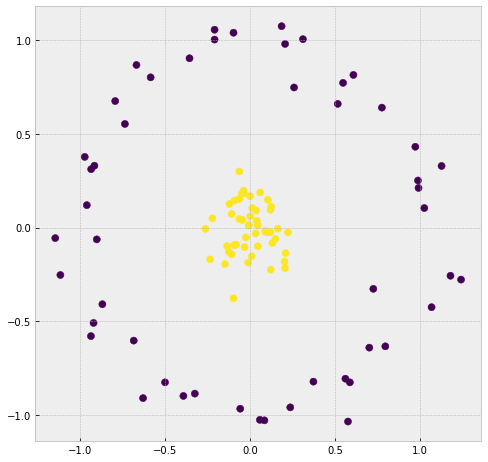

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)
plt.figure(figsize=(8,8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
# plot_svc_decision_function(clf);

Está claro que ninguna discriminación lineal separará estos datos. Una forma de ajustar esto es aplicar un kernel, que es alguna transformación funcional de los datos de entrada.

Por ejemplo, un modelo sencillo que podríamos utilizar es una función de base radial



In [ ]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

Si trazamos esto junto con nuestros datos, podemos ver su efecto:

In [ ]:
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(8,8))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

Podemos ver que con esta dimensión adicional, los datos se vuelven trivialmente separables linealmente. Este es un kernel relativamente sencillo; la SVM tiene una versión más sofisticada de este kernel incorporada al proceso. Esto se consigue utilizando kernel='rbf', abreviatura de función de base radial:


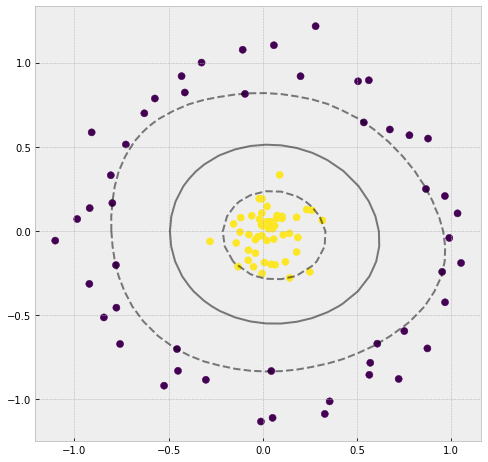

In [ ]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)



Aquí hay efectivamente N funciones base: ¡una centrada en cada punto! Gracias a un ingenioso truco matemático, este cálculo se realiza de forma muy eficiente utilizando el "truco del núcleo", sin necesidad de construir la matriz de evaluaciones del núcleo.

## Interactuemos con un modelo SVM

Para interactuar con un modelo SVM, visitar la página: https://www.csie.ntu.edu.tw/~cjlin/libsvm/#download.

## Ejemplo

In [ ]:
from sklearn import preprocessing, metrics, model_selection
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('https://raw.githubusercontent.com/prof-tatiana-gutierrez/DatosMD/master/breast-cancer-wisconsin.txt', na_values = '?')
df = df.dropna()
df.head()


,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromation,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [ ]:
df.drop(['id'], 1, inplace=True)
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])
y = label_binarize(y, classes=[2,4])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn import svm

svc_clf = svm.SVC()
# Grilla de validación
parameters = {'gamma': np.linspace(0,1,20), 'C': np.linspace(10,1000,50)}
acc_scorer = make_scorer(roc_auc_score)

# Run and fit the grid search
grid_obj = GridSearchCV(svc_clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

grid_obj

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([  10.        ,   30.20408163,   50.40816327,   70.6122449 ,
         90.81632653,  111.02040816,  131.2244898 ,  151.42857143,
        171.63265306,  191.83673469,  212.04081633,  232.24489796,
        252.44897959,  272.65306122,  292.85714286,  313.06122449,
        333.26530612,  353.46938776,  373.67346939,  393.87755102,
        414.08163265,  434.28571429,  454.48979592,  474.69387755,
        4...
        818.16326531,  838.36734694,  858.57142857,  878.7755102 ,
        898.97959184,  919.18367347,  939.3877551 ,  959.59183673,
        979.79591837, 1000.        ]),
                         'gamma': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring=make_scorer(roc_auc_score)

In [ ]:
# Set the clf to the best combination of parameters
svc_clf_best = grid_obj.best_estimator_
svc_clf_best

SVC(C=10.0, gamma=0.10526315789473684)

In [ ]:
# Fit the best algorithm to the data. 
svc_clf_best.fit(X_train, y_train)

svc_pred = svc_clf_best.predict(X_test)

El AUC del modelo SVC es:

In [ ]:
print(accuracy_score(y_test, svc_pred))

0.9707317073170731


### - SVC Validación Cruzada con K-Fold CV

In [ ]:
from sklearn.model_selection import KFold

def cv_kfold(clf, grid_param):
    kf = KFold(n_splits=5)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        parameters = grid_param
        acc_scorer = make_scorer(accuracy_score)
        grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
        grid_obj = grid_obj.fit(X_train, y_train)
        clf_best = grid_obj.best_estimator_
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Parameters:",clf_best)
        print("Fold {0} AUC: {1}".format(fold, accuracy))
        print("------")    
    mean_outcome = np.mean(outcomes)
    print("AUC Promedio: {0}".format(mean_outcome))  

cv_kfold(svc_clf, parameters)

Parameters: SVC(C=10.0, gamma=0.05263157894736842)
Fold 1 AUC: 0.9197080291970803
------
Parameters: SVC(C=10.0, gamma=0.05263157894736842)
Fold 2 AUC: 0.9635036496350365
------
Parameters: SVC(C=10.0, gamma=0.05263157894736842)
Fold 3 AUC: 0.9635036496350365
------
Parameters: SVC(C=10.0, gamma=0.05263157894736842)
Fold 4 AUC: 0.9779411764705882
------
Parameters: SVC(C=10.0, gamma=0.05263157894736842)
Fold 5 AUC: 0.9926470588235294
------
AUC Promedio: 0.9634607127522543
